In [7]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()




def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False,events= None):
    toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False, events=None):
    softdrop_mass = events["FatJet_msoftdrop"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]

def btagging_overlap_removal(target, cleans, cut=0.4, dphi=False,events=None):
    btagging = events["FatJet_btagDeepB"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btagging[mask]

def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btagging[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj["eta"]) < etamax and obj["pt"] > ptmin : output.append(obj)
    return output 

def twoak8cleancut(sample):
    file = uproot.open(sample)
    events = file["Events"]
    keys = events.keys()
    # LHE-level particles
    lhe_pdgid = events["LHEPart_pdgId"].array()
    lhe_pt    = events["LHEPart_pt"].array()
    lhe_eta   = events["LHEPart_eta"].array()
    lhe_phi   = events["LHEPart_phi"].array()
    lhe_mass  = events["LHEPart_mass"].array()

    bottom_mask     = (lhe_pdgid == 5) | (lhe_pdgid == -5)
    lhe_muon_mask   = (lhe_pdgid == 13) | (lhe_pdgid == -13)
    lhe_particle    = ak.zip({
        "pt":   lhe_pt,
        "eta":  lhe_eta,
        "phi":  lhe_phi,
        "mass": lhe_mass
    }, with_name="Momentum4D")

    lhe_bottoms     = lhe_particle[bottom_mask]
    lhe_bottoms_eta  = lhe_bottoms["eta"][:, 1:2]
    lhe_bottoms_phi  = lhe_bottoms["phi"][:, 1:2]
    lhe_bottoms_pt   = lhe_bottoms["pt"][:, 1:2]
    lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]

    lhe_bottom2_eta  = lhe_bottoms["eta"][:, 0:1]
    lhe_bottom2_phi  = lhe_bottoms["phi"][:, 0:1]
    lhe_bottom2_pt   = lhe_bottoms["pt"][:, 0:1]
    lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]

    lhe_bottom = ak.zip({
        "pt":   lhe_bottoms_pt,
        "eta":  lhe_bottoms_eta,
        "phi":  lhe_bottoms_phi,
        "mass": lhe_bottoms_mass
    }, with_name="Momentum4D")
    lhe_bottom2 = ak.zip({
        "pt":   lhe_bottom2_pt,
        "eta":  lhe_bottom2_eta,
        "phi":  lhe_bottom2_phi,
        "mass": lhe_bottom2_mass
    }, with_name="Momentum4D")

    lhe_muons      = lhe_particle[lhe_muon_mask]
    lhe_muons_pt   = lhe_muons["pt"]
    lhe_muons_eta  = lhe_muons["eta"]
    lhe_muons_phi  = lhe_muons["phi"]
    lhe_muons_mass = lhe_muons["mass"]

    n_mother_muon = ak.zip({
        "pt":   lhe_muons_pt[:, 0:1],
        "eta":  lhe_muons_eta[:, 0:1],
        "phi":  lhe_muons_phi[:, 0:1],
        "mass": lhe_muons_mass[:, 0:1]
    }, with_name="Momentum4D")

    wr_mother_muon = ak.zip({
        "pt":   lhe_muons_pt[:, 1:2],
        "eta":  lhe_muons_eta[:, 1:2],
        "phi":  lhe_muons_phi[:, 1:2],
        "mass": lhe_muons_mass[:, 1:2]
    }, with_name="Momentum4D")

    # Gen-level tops
    gen_pids   = events["GenPart_pdgId"].array()
    gen_pts    = events["GenPart_pt"].array()
    gen_etas   = events["GenPart_eta"].array()
    gen_phis   = events["GenPart_phi"].array()
    gen_masses = events["GenPart_mass"].array()
    top_mask   = (gen_pids == 6) | (gen_pids == -6)

    genparticle = ak.zip({
        "pt":   gen_pts,
        "eta":  gen_etas,
        "phi":  gen_phis,
        "mass": gen_masses
    }, with_name="Momentum4D")
    gentops     = genparticle[top_mask]

    gentop = ak.zip({
        "pt":   gentops["pt"][:, 0:1],
        "eta":  gentops["eta"][:, 0:1],
        "phi":  gentops["phi"][:, 0:1],
        "mass": gentops["mass"][:, 0:1]
    }, with_name="Momentum4D")

    # Reco-level objects
    ak4 = ak.zip({
        "pt":   events["Jet_pt"].array(),
        "eta":  events["Jet_eta"].array(),
        "phi":  events["Jet_phi"].array(),
        "mass": events["Jet_mass"].array()
    }, with_name="Momentum4D")

    fatjets = ak.zip({
        "pt":   events["FatJet_pt"].array(),
        "eta":  events["FatJet_eta"].array(),
        "phi":  events["FatJet_phi"].array(),
        "mass": events["FatJet_mass"].array()
    }, with_name="Momentum4D")

    reco_muons = ak.zip({
        "pt":   events["Muon_pt"].array(),
        "eta":  events["Muon_eta"].array(),
        "phi":  events["Muon_phi"].array(),
        "mass": events["Muon_mass"].array()
    }, with_name="Momentum4D")
    
    btagging = events["FatJet_btagDeepB"].array()
    toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
    softdrop_mass = events["FatJet_msoftdrop"].array()
    first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
    second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온
    sortidx = ak.argsort(-reco_muons["pt"], axis=1)  # pt 기준으로 내림차순 정렬
    first_muon = reco_muons[sortidx][:, 0:1]  # 가장 큰 pt를 가진 뮤온
    second_muon = reco_muons[sortidx][:, 1:2]  # 두 번째로 큰 pt를 가진 뮤온
    
    # Overlap removal
    muon_iso = events["Muon_tkRelIso"].array() 
    muon_highpt_id = events["Muon_highPtId"].array()

    leading_muon_iso = muon_iso[sortidx][:, 0:1]
    leading_muon_hpt = muon_highpt_id[sortidx][:, 0:1]
    subleading_muon_iso = muon_iso[sortidx][:, 1:2]
    subleading_muon_hpt = muon_highpt_id[sortidx][:, 1:2]

    first_muon_cleaned  = overlap_removal(first_muon, [reco_muons], cut=0.4)
    second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)

    signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
    toptaggedak8 = toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8,events=events)
    softdrop_mass_ak8 = sdm_toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8,events=events)
    #btaggingak8 = btagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)

    idx_desc = ak.argsort(-signaltop_cleaned["pt"], axis=1)

    toptagging_mask = toptaggedak8 > 0.9  # ParticleNet T vs QCD threshold
    softdrop_mass_mask = (softdrop_mass_ak8 > 120) & (softdrop_mass_ak8 < 250)   # SoftDrop mass threshold
    total_top_mask = toptagging_mask & softdrop_mass_mask

    cleaned_toptagged_ak8 = signaltop_cleaned[total_top_mask]  # top tagging 된 애들만 남김
    idx_cleaned_toptagged_ak8 = ak.argsort(-cleaned_toptagged_ak8["pt"], axis=1)
    leading_toptagged_ak8 = cleaned_toptagged_ak8[idx_cleaned_toptagged_ak8][:, 0:1]  # 가장 큰 pt

    ## top을 제외한 나머지 ak8 중 제일 큰 pt

    cleaned_bjet_ak8 = signaltop_cleaned[~toptagging_mask]
    idx_cleaned_bjet_ak8 = ak.argsort(-cleaned_bjet_ak8["pt"], axis=1)
    leading_bjet_ak8 = cleaned_bjet_ak8[idx_cleaned_bjet_ak8][:, 0:1]  # 가장 큰 pt

    # Apply event selection
    pt1 = ak.sum(first_muon_cleaned["pt"], axis=1)
    pt2 = ak.sum(second_muon_cleaned["pt"], axis=1)
    eta1= ak.sum(first_muon_cleaned["eta"], axis=1)
    eta2= ak.sum(second_muon_cleaned["eta"], axis=1)
    pt_leading_topjets = ak.sum(leading_toptagged_ak8["pt"], axis=1)
    pt_leading_bjets   = ak.sum(leading_bjet_ak8["pt"], axis=1)
    hlt = events["HLT_IsoMu30"].array()
    
    mask_evt = (
        (pt1 > 0) & (pt2 > 0) &
        #(abs(eta1) < 2.4) & (abs(eta2) < 2.4) &
        (pt_leading_topjets > 0) & (pt_leading_bjets > 0)
    )
    
    hlt_mask = (
        (pt1 > 0) & (pt2 > 0) &
        (pt_leading_topjets > 0) & (pt_leading_bjets > 0) & (hlt==True)
    )
    hltpassev     = len(ak.flatten(first_muon_cleaned["pt"][hlt_mask]))
    first_muon_cleaned  = first_muon_cleaned[mask_evt]
    second_muon_cleaned = second_muon_cleaned[mask_evt]
    leading_topjets     = leading_toptagged_ak8[mask_evt]
    leading_bjets       = leading_bjet_ak8[mask_evt]
    
    lmi = leading_muon_iso[mask_evt]
    lmhpt = leading_muon_hpt[mask_evt]
    slmi = subleading_muon_iso[mask_evt]
    slhpt = subleading_muon_hpt[mask_evt]
    # Dilepton mass cut
    mll = (first_muon_cleaned + second_muon_cleaned).mass
    mll_mask = mll > 0
    first_muon_cleaned  = first_muon_cleaned[mll_mask]
    second_muon_cleaned = second_muon_cleaned[mll_mask]
    leading_topjets     = leading_topjets[mll_mask]
    leading_bjets       = leading_bjets[mll_mask]
    
    # Final variables
    combined_p4               = (first_muon_cleaned + second_muon_cleaned + leading_topjets + leading_bjets).mass
    mN                        = (first_muon_cleaned + leading_topjets + leading_bjets).mass
    first_muon_cleaned_pt_sum = ak.sum(first_muon_cleaned["pt"], axis=1)
    second_muon_cleaned_pt_sum= ak.sum(second_muon_cleaned["pt"], axis=1)
    mll                       = (first_muon_cleaned + second_muon_cleaned).mass
    total_events = len(lhe_pt)
    left_events = len(combined_p4)
    
    
    return combined_p4, mN, first_muon_cleaned_pt_sum, second_muon_cleaned_pt_sum, mll,leading_topjets["pt"],leading_bjets["pt"] ,lmi,slmi, lmhpt, slhpt ,total_events, left_events,hltpassev

def iter_allfile (path):
    from importlib import import_module
    import os
    import sys
    import argparse
    import linecache
    import uproot
    import vector
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    import awkward as ak
    from tqdm import tqdm  # ✅ 진행률 표시
    import glob
    
    file_list = sorted(glob.glob(path + "*.root"))
    
    combined_p4_list = []
    mll_list = []
    lb_list = []
    lt_list = []
    mu1_pt_list = []
    mu2_pt_list = []
    lmi_list = []
    lmh_list = []
    smi_list = []
    smh_list = []
    btag_list = []
    totalev_list = 0
    leftev_list = 0
    hltpassev_list = 0

    # tqdm으로 파일 리스트 순회
    for sample in tqdm(file_list, desc="Processing ROOT files"):

        combined_p4, mN, mu1_pt, mu2_pt, mll,lt,lb ,lmi,slmi, lmhpt, slhpt ,totalev, leftev,hltpassev = twoak8cleancut(sample)

        combined_p4_list.append(combined_p4)
        mll_list.append(mll)
        mu1_pt_list.append(mu1_pt)
        mu2_pt_list.append(mu2_pt)
        lt_list.append(lt)
        lb_list.append(lb)
        totalev_list += totalev
        leftev_list += leftev
        hltpassev_list += hltpassev
        lmi_list.append(lmi)
        lmh_list.append(lmhpt)
        smi_list.append(slmi)
        smh_list.append(slhpt)
    return (combined_p4_list, mll_list, mu1_pt_list, mu2_pt_list,lt_list,lb_list, lmi_list, lmh_list, smi_list, smh_list,totalev_list, leftev_list, hltpassev_list)
            # 0. combined_p4_list
            # 1. mll_list
            # 2. mu1_pt_list
            # 3. mu2_pt_list
            # 4. lt_list
            # 5. lb_list
            # 6. lmi_list
            # 7. lmh_list
            # 8. smi_list
            # 9. smh_list
            # 10. totalev_list
            # 11. leftev_list
            # 12. hltpassev_list



In [15]:
## main back  = ttH , ttZ , ttW , ttbar , tzj

singal1070 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-1000_MN-700_13p6TeV/"
signal3013 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-3000_MN-1300_13p6TeV/"
signal3021 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-3000_MN-2100_13p6TeV/"
signal3029 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-3000_MN-2900_13p6TeV/"
signal5025 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV/"
signal5033 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-3300_13p6TeV/"
signal5041 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4100_13p6TeV/"
signal5049 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/"


## TW ( hadronic W )
twm_2l2nu = "/gv0/Users/achihwan/TbarWplusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_18.root"
twm_2l2nu_all = "/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TbarWplusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/*/*/"
twp_2l2nu = "/gv0/Users/achihwan/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
twp_2l2nu_all = "/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/240702_155308/0000/"
tw_lnu2q = "/gv0/Users/achihwan/TbarWplustoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/tree_100.root"
tw_lnu2q_all = "//gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TbarWplustoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/240702_154329/0000/"

## TZJ

## TTH
tth_mumu = "/gv0/Users/achihwan/TTH_Hto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
tth_mumu_all = "/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TTH_Hto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/240808_054050/0000/"
tth_zz = "/gv0/Users/achihwan/TTH_Hto2Z_M-125_4LFilter_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/tree_13.root"
tth_zz_all = "/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TTH_Hto2Z_M-125_4LFilter_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/240808_054104/0000/"

## TTZ
ttz_mumu = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/using_matrix/cleaning/backgroundsample/08528f47-e513-4c27-9e86-a76cdca78fe8.root "

## TTW


### signal 5049

In [9]:
data = iter_allfile(signal5049)

Processing ROOT files: 100%|██████████| 80/80 [02:00<00:00,  1.51s/it]


signal efficiency :  26.900000000000002 %
signal efficiency after HLT :  26.375 %


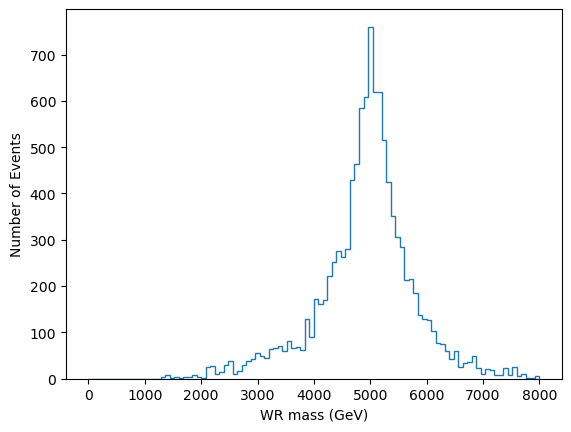

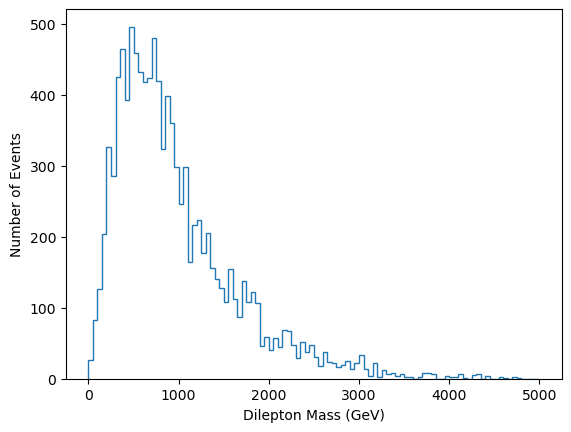

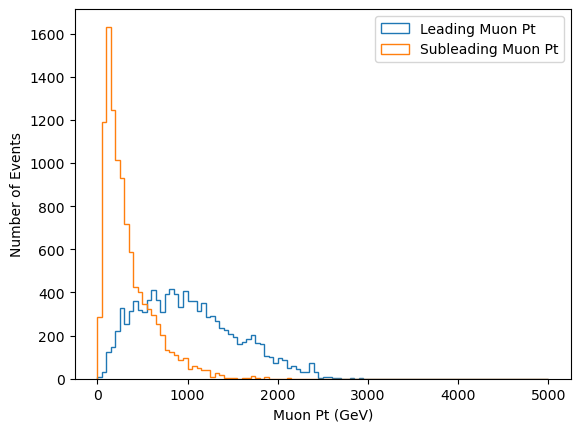

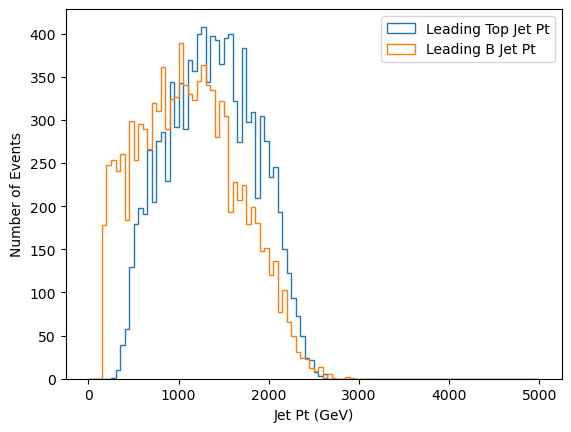

In [13]:
print("signal efficiency : ", data[11]/data[10]* 100, "%")
print("signal efficiency after HLT : ", data[12]/data[10]* 100, "%")
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 5000), histtype='step', label='Dilepton Mass')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 5000), histtype='step', label='Leading Muon Pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 5000), histtype='step', label='Subleading Muon Pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 5000), histtype='step', label='Leading Top Jet Pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 5000), histtype='step', label='Leading B Jet Pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()



### Signal 5025

In [14]:
data = iter_allfile(signal5025)

Processing ROOT files: 100%|██████████| 114/114 [02:39<00:00,  1.40s/it]


signal efficiency :  28.23684210526316 %
signal efficiency after HLT :  27.705263157894738 %


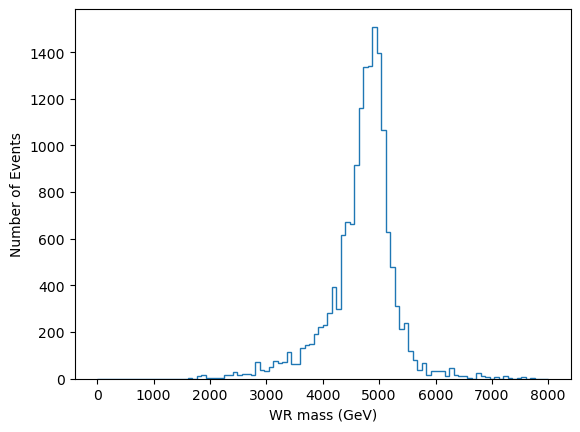

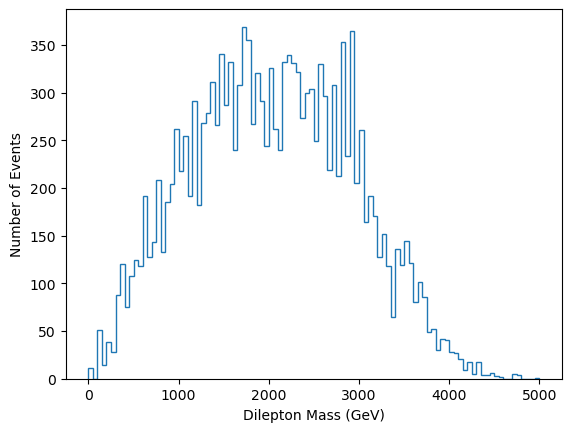

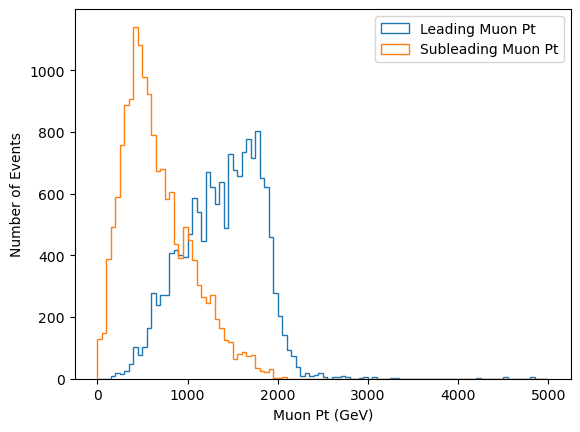

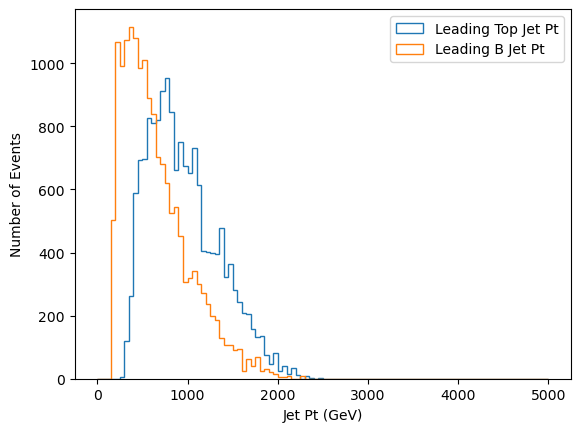

In [16]:
print("signal efficiency : ", data[11]/data[10]* 100, "%")
print("signal efficiency after HLT : ", data[12]/data[10]* 100, "%")
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 5000), histtype='step', label='Dilepton Mass')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 5000), histtype='step', label='Leading Muon Pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 5000), histtype='step', label='Subleading Muon Pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 5000), histtype='step', label='Leading Top Jet Pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 5000), histtype='step', label='Leading B Jet Pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()



### TW(twm_2l2nu)

In [17]:
data = iter_allfile(twm_2l2nu_all)

Processing ROOT files: 100%|██████████| 73/73 [03:14<00:00,  2.66s/it]


signal efficiency :  0.0023558130702946187 %
signal efficiency after HLT :  0.0016246986691687028 %


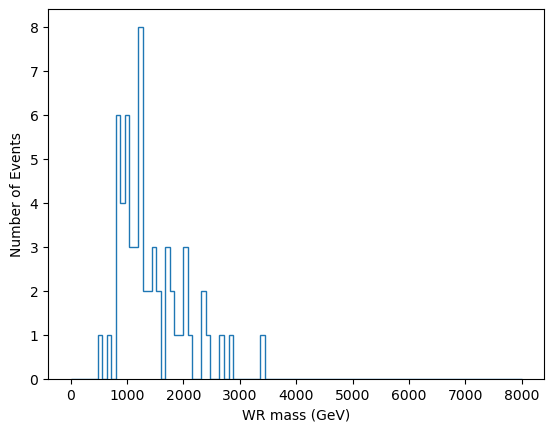

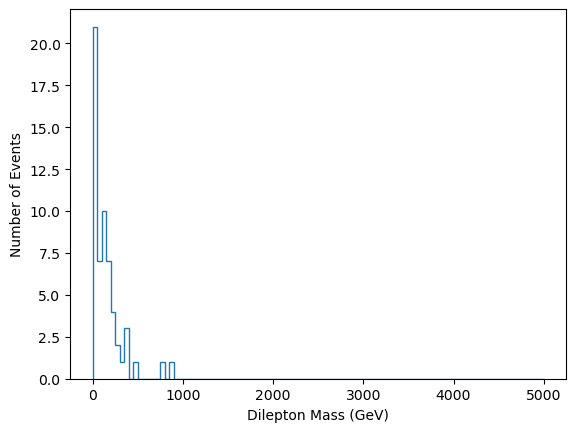

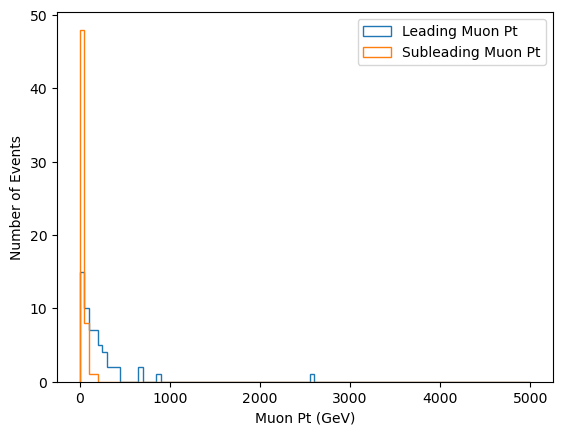

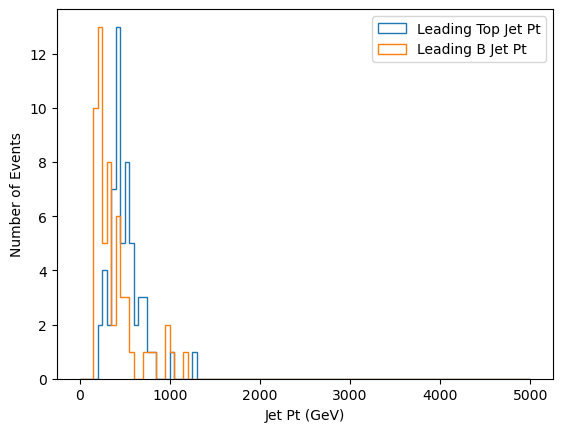

In [18]:
print("signal efficiency : ", data[11]/data[10]* 100, "%")
print("signal efficiency after HLT : ", data[12]/data[10]* 100, "%")
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 5000), histtype='step', label='Dilepton Mass')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 5000), histtype='step', label='Leading Muon Pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 5000), histtype='step', label='Subleading Muon Pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 5000), histtype='step', label='Leading Top Jet Pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 5000), histtype='step', label='Leading B Jet Pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()



### TW(twp_2l2nu)

In [19]:
data =iter_allfile(twp_2l2nu_all)

Processing ROOT files: 100%|██████████| 56/56 [03:01<00:00,  3.23s/it]


signal efficiency :  0.001920536213710868 %
signal efficiency after HLT :  0.001160323962450316 %


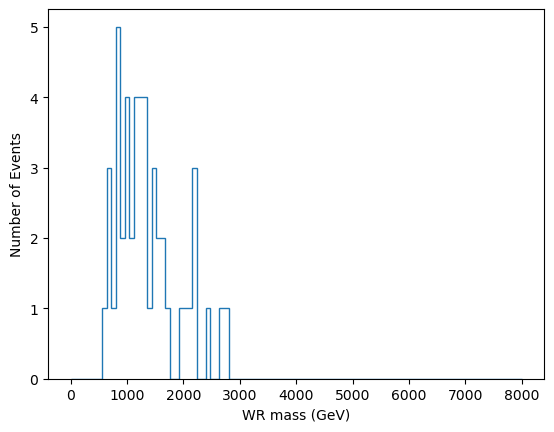

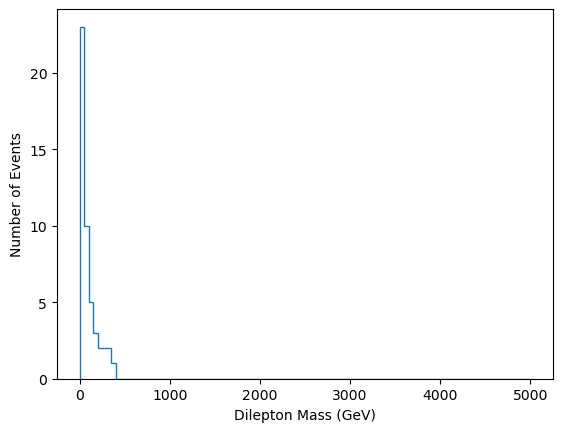

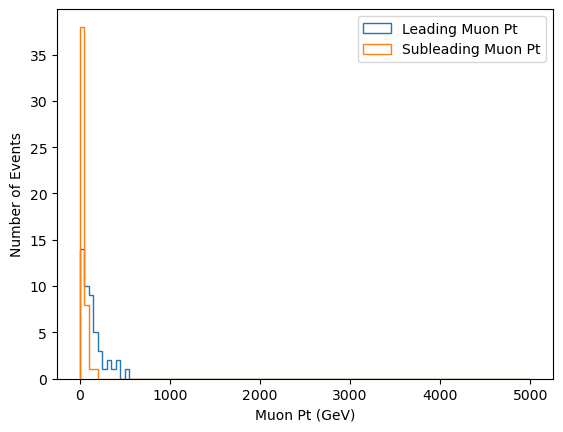

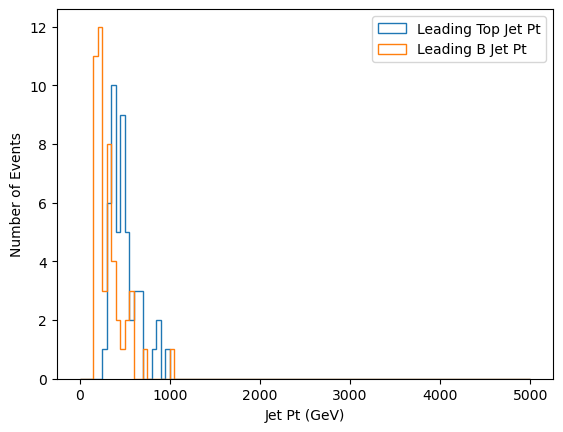

In [20]:
print("signal efficiency : ", data[11]/data[10]* 100, "%")
print("signal efficiency after HLT : ", data[12]/data[10]* 100, "%")
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 5000), histtype='step', label='Dilepton Mass')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 5000), histtype='step', label='Leading Muon Pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 5000), histtype='step', label='Subleading Muon Pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 5000), histtype='step', label='Leading Top Jet Pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 5000), histtype='step', label='Leading B Jet Pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()



### TW (tw_lnu2q)

In [21]:
data = iter_allfile(tw_lnu2q_all)

Processing ROOT files: 100%|██████████| 116/116 [06:37<00:00,  3.43s/it]


signal efficiency :  0.0085967629579709 %
signal efficiency after HLT :  0.004659156902881111 %


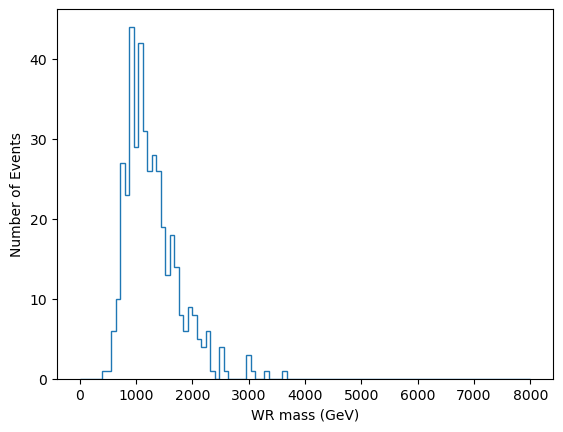

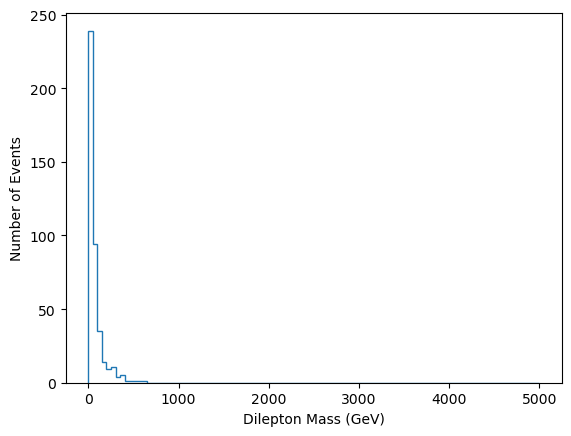

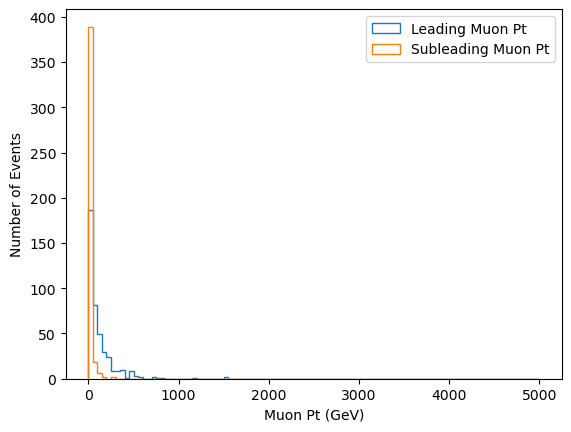

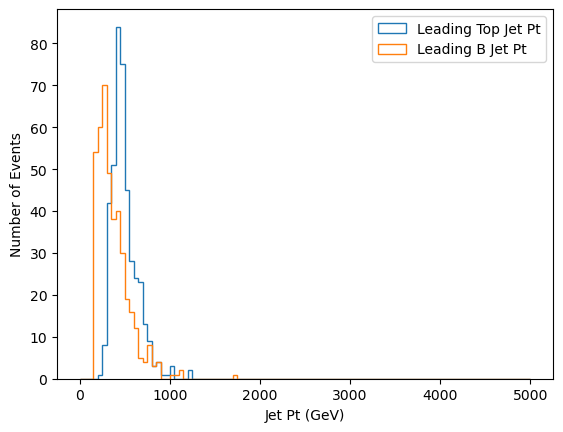

In [22]:
print("signal efficiency : ", data[11]/data[10]* 100, "%")
print("signal efficiency after HLT : ", data[12]/data[10]* 100, "%")
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 5000), histtype='step', label='Dilepton Mass')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 5000), histtype='step', label='Leading Muon Pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 5000), histtype='step', label='Subleading Muon Pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 5000), histtype='step', label='Leading Top Jet Pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 5000), histtype='step', label='Leading B Jet Pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()



### TTH(tth_mumu)

In [24]:
data = iter_allfile(tth_mumu_all)

Processing ROOT files: 100%|██████████| 28/28 [00:51<00:00,  1.86s/it]


signal efficiency :  1.1077425373134329 %
signal efficiency after HLT :  1.062621674237508 %


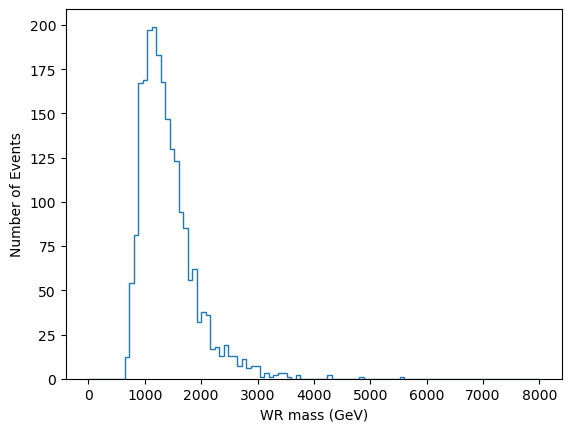

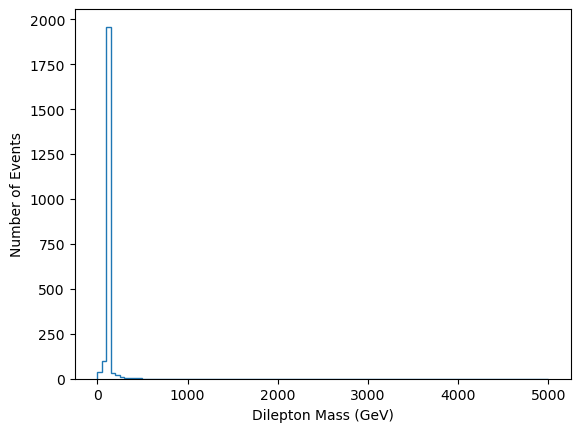

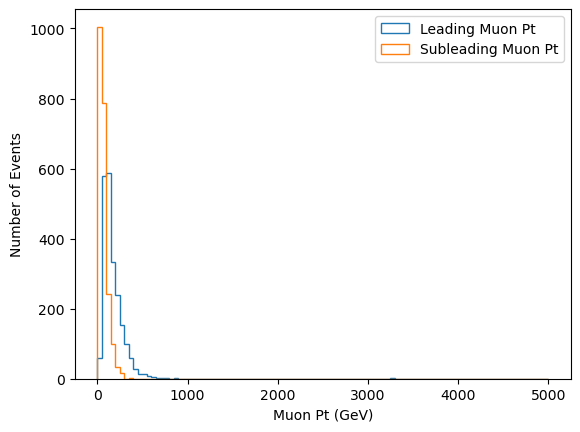

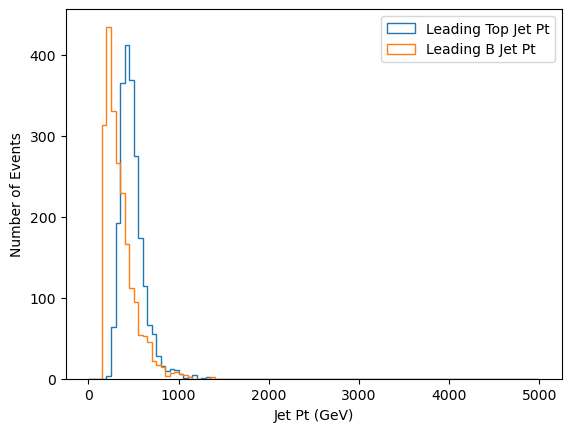

In [25]:
print("signal efficiency : ", data[11]/data[10]* 100, "%")
print("signal efficiency after HLT : ", data[12]/data[10]* 100, "%")
plt.hist(ak.flatten(data[0]), bins=100, range=(0, 8000), histtype='step', label='Combined P4')
plt.xlabel('WR mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[1]), bins=100, range=(0, 5000), histtype='step', label='Dilepton Mass')
plt.xlabel('Dilepton Mass (GeV)')
plt.ylabel('Number of Events')
plt.show()
plt.hist(ak.flatten(data[2]), bins=100, range=(0, 5000), histtype='step', label='Leading Muon Pt')
plt.hist(ak.flatten(data[3]), bins=100, range=(0, 5000), histtype='step', label='Subleading Muon Pt')
plt.xlabel('Muon Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()
plt.hist(ak.flatten(data[4]), bins=100, range=(0, 5000), histtype='step', label='Leading Top Jet Pt')
plt.hist(ak.flatten(data[5]), bins=100, range=(0, 5000), histtype='step', label='Leading B Jet Pt')
plt.xlabel('Jet Pt (GeV)')
plt.ylabel('Number of Events')
plt.legend()
plt.show()



### TTH(tth_zz)